# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


### Загрузка данных

In [2]:
data_0 = pd.read_csv("/datasets/geo_data_0.csv")
data_1 = pd.read_csv("/datasets/geo_data_1.csv")
data_2 = pd.read_csv("/datasets/geo_data_2.csv")

print(data_0.head())
print()
print(data_1.head())
print()
print(data_2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


### Подготовка данных

In [3]:
print(data_0.info())
print(  )    
print(data_1.info())
print( )     
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

*На первый взгляд дубликатов и пропусков нет, но лучше проверить себя*

In [4]:
#dup check
#data_0.duplicated().sum()
#data_1.duplicated().sum()
#data_2.duplicated().sum()

In [5]:
#nul_check
#data_0.isnull().sum()
#data_1.isnull().sum()
#data_2.isnull().sum()


Перед нами 3 датасета с уникальными значениям. 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Пропусков и явных дубликатов нет,  датасеты предподготовлены к моделированию.

### Распрределение признаков

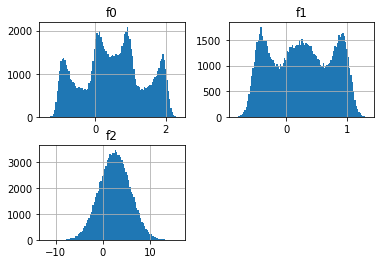

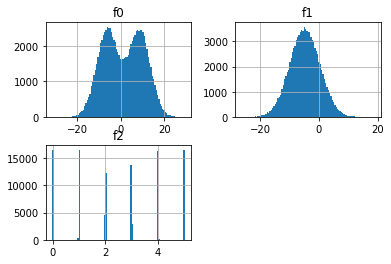

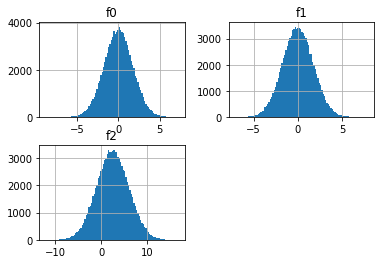

In [6]:
data_0[["f0","f1","f2"]].hist(bins=(100));
data_1[["f0","f1","f2"]].hist(bins=(100));
data_2[["f0","f1","f2"]].hist(bins=(100));

Признаки в 3х датасетах имеют нормальное или близкое к нему распределение, исключением является только f2 в data_1

## Обучение и проверка модели

Для начала разобьем данные на обучающую ит валидационные выборки 

Затем построим модель для каждого датасета 

Получим метрики модели: 
- Корень из среднеквадратичной ошибки (RMSE)
- Среднее значение ископаемого в скважине

### data_0 


In [7]:
features_0 = data_0.drop(["product","id"], axis=1)
target_0 = data_0["product"]
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, 
                                                                                  target_0, 
                                                                                  test_size=0.25, 
                                                                                  random_state=1)

In [8]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)

LinearRegression()

In [9]:
predictions_0 = model_0.predict(features_valid_0)
predictions_0 = pd.Series(predictions_0)
rmse_0 = (mean_squared_error(predictions_0, target_valid_0))**(0.5)
mean_0 = sum(predictions_0) / len(predictions_0)

In [10]:
print("RMSE для data_0: {0:.2f}".format(rmse_0))
print("Среднее значение ископаемого для data_0: {0:.2f}".format(mean_0))

RMSE для data_0: 37.74
Среднее значение ископаемого для data_0: 92.49


### data_1 

In [11]:
features_1 = data_1.drop(["product","id"], axis=1)
target_1 = data_1["product"]
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, 
                                                                                  target_1, 
                                                                                  test_size=0.25, 
                                                                                  random_state=1)

In [12]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)

LinearRegression()

In [13]:
predictions_1 = model_1.predict(features_valid_1)
predictions_1 = pd.Series(predictions_1)
rmse_1 = (mean_squared_error(predictions_1, target_valid_1))**(0.5)
mean_1 = sum(predictions_1) / len(predictions_1)

In [14]:
print("RMSE для data_1: {0:.2f}".format(rmse_1))
print("Среднее значение ископаемого для data_1: {0:.2f}".format(mean_1))

RMSE для data_1: 0.89
Среднее значение ископаемого для data_1: 69.12


### data_2

In [15]:
features_2 = data_2.drop(["product","id"], axis=1)
target_2 = data_2["product"]
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, 
                                                                                  target_2, 
                                                                                  test_size=0.25, 
                                                                                  random_state=1)

In [16]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)

LinearRegression()

In [17]:
predictions_2 = model_2.predict(features_valid_2)
predictions_2 = pd.Series(predictions_2)
rmse_2 = (mean_squared_error(predictions_2, target_valid_2))**(0.5)
mean_2 = sum(predictions_2) / len(predictions_2)

In [18]:
print("RMSE для data_2: {0:.2f}".format(rmse_2))
print("Среднее значение ископаемого  для data_2: {0:.2f}".format(mean_2))

RMSE для data_2: 39.87
Среднее значение ископаемого  для data_2: 94.96


Сравним значения : 

In [19]:
print("RMSE для data_0: {0:.2f}".format(rmse_0))
print("RMSE для data_1: {0:.2f}".format(rmse_1))
print("RMSE для data_2: {0:.2f}".format(rmse_2))

print("----------------------------------------------------------")
print("Среднее значение ископаемого  для data_0: {0:.2f}".format(mean_0))
print("Среднее значение ископаемого  для data_1: {0:.2f}".format(mean_1))
print("Среднее значение ископаемого  для data_2: {0:.2f}".format(mean_2))

RMSE для data_0: 37.74
RMSE для data_1: 0.89
RMSE для data_2: 39.87
----------------------------------------------------------
Среднее значение ископаемого  для data_0: 92.49
Среднее значение ископаемого  для data_1: 69.12
Среднее значение ископаемого  для data_2: 94.96


Разьяснение показателей: 
RMSE - Корень из среднеквадратической ошибки, соответственно нас интересует модель с его наименьшим значением 

data_1 имеет самый низкий RMSE, что говорит нам о том, что она способна лучше всего соответствовать набору данных, однако стоит понимать что распределение всех признаков в data_1 нельзя назвать нормальным, что сказывается на результате.

Однако data_1 имеет наихудший показатель предсказанного серднего значения сырья

## Подготовка к расчёту прибыли

Из тз имеем:

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Вносим данные в проект:

In [20]:
total_budget = 10**10 
barrel_income = 450 * 10**3  

Исходя из этих данных можем расчитать точку безубыточности для разработки

In [21]:
n = total_budget / barrel_income
print("Точка безубыточности: {0:.0f} баррелей".format(n))


Точка безубыточности: 22222 баррелей


In [22]:
t = n / 200
print("Точко безубыточности в обьеме нефти для скажины:",t )

Точко безубыточности в обьеме нефти для скажины: 111.11111111111111


- Запас нефти в скважинах ниже точки безубыточности

## Расчёт прибыли и рисков 

Из тз имеем: 
    
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Соттветственно нам нужно отобрать 200 лучших точек согласно предсказанию для всех датасетов, умножить на доход от каждой единицы соответственно и вычесть из полученного вложенные средства

In [23]:
#main_prediction_0 = predictions_0.sort_values(ascending=False)
#main_target_0 = target_0[main_prediction_0.index][:200]
#revenue_0 = main_target_0.sum() * barrel_income
#income_0 = revenue_0 - total_budget

In [24]:
#main_prediction_1 = predictions_1.sort_values(ascending=False)
#main_target_1 = target_1[main_prediction_1.index][:200]
#revenue_1 = main_target_1.sum() * barrel_income
#income_1 = revenue_1 - total_budget

In [25]:
#main_prediction_2 = predictions_2.sort_values(ascending=False)
#main_target_2 = target_2[main_prediction_2.index][:200]
#revenue_2 = main_target_2.sum() * barrel_income
#income_2 = revenue_2 - total_budget

In [26]:
#print("Потенциальная прибыль для data_0: {0:.1f}".format(income_0))
#print("Потенциальная прибыль для data_1: {0:.1f}".format(income_1))
#print("Потенциальная прибыль для data_2: {0:.1f}".format(income_2))

In [27]:
def income(predictions, target):
    main_prediction = predictions.sort_values(ascending=False)
    main_target = target[main_prediction.index][:200]
    revenue = main_target.sum() * barrel_income
    return revenue - total_budget


Вычислить сложные величины, не прибегая к формулам, поможет техника Bootstrap (англ. «самовытягивание»)

In [28]:
state = np.random.RandomState(12345)

In [33]:
def risk_find(predictions, target):
    revenue = []
    
    for _ in range(1000):
        target_sample = target.sample(n=500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]

        revenue.append(income(predictions_sample, target_sample))  
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)


In [34]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)


In [44]:
print('Регион 1(data_0) доверительный интервал, средняя прибыль,риск убытков:', 
      risk_find(predictions_0, target_valid_0))
print('Регион 2(data_0) доверительный интервал, средняя прибыль, риск убытков:', 
      risk_find(predictions_1, target_valid_1))
print('Регион 3(data_0) доверительный интервал, средняя прибыль, риск убытков:', 
      risk_find(predictions_2, target_valid_2))

Регион 1(data_0) доверительный интервал, средняя прибыль,риск убытков: ((-75287193, 1000212982), 468985838, 4.6000000000000005)
Регион 2(data_0) доверительный интервал, средняя прибыль, риск убытков: ((113061541, 961467265), 531439824, 0.2)
Регион 3(data_0) доверительный интервал, средняя прибыль, риск убытков: ((-159616325, 950564306), 398206851, 9.200000000000001)


## Вывод

- Ход исследования:

1.  В первой части работы я изучил предоставленные данные, провел исследовательский анализ данных, проверил датасеты на наличие пропусков, дупликатов, а также посмотрел на распределения признаков по каждому региону, которые, в большинстве своем, оказались распределены не нормально.
2. Построил линейную модель, изучил ее предсказания и показатели 
3. Далее я выявил ключевые параметры для выявления экономической эффективности региона
4. Затем  выполнил процедуру бутстрэпа и поиск 95% доверительный интервала для среднего объема нефти в скважинах. 
5. Составил рейтинг регионов основываясь на полученных показателях и привел заключение по исследованию

- Рейтинг представленных регионов:

1. Регион 2 
2. Регион 1
3. Регион 3



- Аналитическое заключение по исследованию:

**Наиболее перспективным для разработки представляется регион № 2, поскольку риски убытков наименьшие(более чем в 20 раз от ближайшего показателя в рейтинге - регион №1), а средняя прибыль наибольшая(более 13%  от ближайшего показателя в рейтинге - регион №1).**